<a href="https://colab.research.google.com/github/sid-betalol/Document-Classification-Models/blob/main/DiT_finetuning_rvlcdip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install transformers[torch] -U
# !pip install datasets

In [11]:
import numpy as np
import torch
from datasets import load_dataset
from transformers import AutoModelForImageClassification, AutoFeatureExtractor, TrainingArguments, Trainer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import io
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import IterableDataset
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
task = 'rvl-cdip'

In [5]:
torch.manual_seed(42)
np.random.seed(42)

In [6]:
num_labels = 16

In [7]:
train_data_dir = f"/content/drive/MyDrive/rvl-cdip-pp/DiT/{task}/train_data"
eval_data_dir = f"/content/drive/MyDrive/rvl-cdip-pp/DiT/{task}/eval_data"

In [8]:
class PreprocessedDataset(Dataset):
    def __init__(self, data_dir):
        self.data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.pt')]

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        pixel_values, label = torch.load(self.data_files[idx])
        return {"pixel_values": pixel_values, "labels": label}

In [12]:
train_dataset = PreprocessedDataset(train_data_dir)
eval_dataset = PreprocessedDataset(eval_data_dir)

In [13]:
model = AutoModelForImageClassification.from_pretrained("microsoft/dit-base", num_labels=num_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/dit-base and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    # Optionally print a classification report here or save it to a file
    report = classification_report(labels, predictions, target_names=[f'Class {i}' for i in range(num_labels)], digits=4)
    print(report)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [15]:
training_args = TrainingArguments(
    output_dir=f"/content/drive/MyDrive/rvl-cdip-pp/DiT/{task}/results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f"/content/drive/MyDrive/rvl-cdip-pp/DiT/{task}/logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    # Since we're aiming for 3 epochs, max_steps might not be necessary here
    # but if you choose to use it, set max_steps=600
    max_steps=1000  # Optional based on the above explanation
)

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [17]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.038400,2.035115,0.318750,0.260907,0.316613,0.318750
2,1.482100,1.191417,0.681250,0.653108,0.647458,0.681250
3,0.848200,0.921614,0.750000,0.730305,0.749098,0.750000
4,0.557700,0.867747,0.762500,0.757560,0.770637,0.762500
5,0.339800,0.876207,0.800000,0.798871,0.810164,0.800000


              precision    recall  f1-score   support

     Class 0     0.0000    0.0000    0.0000        10
     Class 1     0.0000    0.0000    0.0000        10
     Class 2     0.2857    0.8000    0.4211        10
     Class 3     1.0000    0.4000    0.5714        10
     Class 4     0.4667    0.7000    0.5600        10
     Class 5     0.0000    0.0000    0.0000        10
     Class 6     0.4737    0.9000    0.6207        10
     Class 7     0.0000    0.0000    0.0000        10
     Class 8     1.0000    0.3000    0.4615        10
     Class 9     0.3636    0.4000    0.3810        10
    Class 10     0.5000    0.2000    0.2857        10
    Class 11     0.4286    0.3000    0.3529        10
    Class 12     0.0000    0.0000    0.0000        10
    Class 13     0.1475    0.9000    0.2535        10
    Class 14     0.0000    0.0000    0.0000        10
    Class 15     0.4000    0.2000    0.2667        10

    accuracy                         0.3187       160
   macro avg     0.3166   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

     Class 0     0.7778    0.7000    0.7368        10
     Class 1     0.4444    0.4000    0.4211        10
     Class 2     0.9000    0.9000    0.9000        10
     Class 3     0.9000    0.9000    0.9000        10
     Class 4     0.8000    0.8000    0.8000        10
     Class 5     0.0000    0.0000    0.0000        10
     Class 6     0.9091    1.0000    0.9524        10
     Class 7     0.6667    0.4000    0.5000        10
     Class 8     0.9091    1.0000    0.9524        10
     Class 9     0.6154    0.8000    0.6957        10
    Class 10     0.3333    0.2000    0.2500        10
    Class 11     0.5385    0.7000    0.6087        10
    Class 12     0.7000    0.7000    0.7000        10
    Class 13     0.8889    0.8000    0.8421        10
    Class 14     0.5000    0.6000    0.5455        10
    Class 15     0.4762    1.0000    0.6452        10

    accuracy                         0.6813       160
   macro avg     0.6475   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

     Class 0     0.6923    0.9000    0.7826        10
     Class 1     0.6000    0.3000    0.4000        10
     Class 2     0.9091    1.0000    0.9524        10
     Class 3     0.9000    0.9000    0.9000        10
     Class 4     0.8000    0.8000    0.8000        10
     Class 5     0.6364    0.7000    0.6667        10
     Class 6     0.7500    0.9000    0.8182        10
     Class 7     0.7000    0.7000    0.7000        10
     Class 8     1.0000    0.9000    0.9474        10
     Class 9     0.7000    0.7000    0.7000        10
    Class 10     0.5000    0.1000    0.1667        10
    Class 11     0.5714    0.8000    0.6667        10
    Class 12     0.6000    0.9000    0.7200        10
    Class 13     0.7692    1.0000    0.8696        10
    Class 14     0.8571    0.6000    0.7059        10
    Class 15     1.0000    0.8000    0.8889        10

    accuracy                         0.7500       160
   macro avg     0.7491   

TrainOutput(global_step=1000, training_loss=1.2561053730249405, metrics={'train_runtime': 584.6896, 'train_samples_per_second': 13.682, 'train_steps_per_second': 1.71, 'total_flos': 6.20085842804736e+17, 'train_loss': 1.2561053730249405, 'epoch': 5.0})

In [18]:
trainer.evaluate()

              precision    recall  f1-score   support

     Class 0     0.7500    0.9000    0.8182        10
     Class 1     0.4444    0.4000    0.4211        10
     Class 2     0.9091    1.0000    0.9524        10
     Class 3     0.9000    0.9000    0.9000        10
     Class 4     0.8000    0.8000    0.8000        10
     Class 5     0.6000    0.6000    0.6000        10
     Class 6     1.0000    0.9000    0.9474        10
     Class 7     0.8889    0.8000    0.8421        10
     Class 8     0.9000    0.9000    0.9000        10
     Class 9     0.7500    0.9000    0.8182        10
    Class 10     0.5833    0.7000    0.6364        10
    Class 11     0.7778    0.7000    0.7368        10
    Class 12     0.7500    0.9000    0.8182        10
    Class 13     1.0000    0.8000    0.8889        10
    Class 14     1.0000    0.6000    0.7500        10
    Class 15     0.9091    1.0000    0.9524        10

    accuracy                         0.8000       160
   macro avg     0.8102   

{'eval_loss': 0.8762070536613464,
 'eval_accuracy': 0.8,
 'eval_f1': 0.7988705191007822,
 'eval_precision': 0.8101641414141414,
 'eval_recall': 0.8,
 'eval_runtime': 2.6191,
 'eval_samples_per_second': 61.09,
 'eval_steps_per_second': 7.636,
 'epoch': 5.0}

In [19]:
predictions = trainer.predict(eval_dataset)
labels = predictions.label_ids
preds = np.argmax(predictions.predictions, axis=-1)

              precision    recall  f1-score   support

     Class 0     0.7500    0.9000    0.8182        10
     Class 1     0.4444    0.4000    0.4211        10
     Class 2     0.9091    1.0000    0.9524        10
     Class 3     0.9000    0.9000    0.9000        10
     Class 4     0.8000    0.8000    0.8000        10
     Class 5     0.6000    0.6000    0.6000        10
     Class 6     1.0000    0.9000    0.9474        10
     Class 7     0.8889    0.8000    0.8421        10
     Class 8     0.9000    0.9000    0.9000        10
     Class 9     0.7500    0.9000    0.8182        10
    Class 10     0.5833    0.7000    0.6364        10
    Class 11     0.7778    0.7000    0.7368        10
    Class 12     0.7500    0.9000    0.8182        10
    Class 13     1.0000    0.8000    0.8889        10
    Class 14     1.0000    0.6000    0.7500        10
    Class 15     0.9091    1.0000    0.9524        10

    accuracy                         0.8000       160
   macro avg     0.8102   

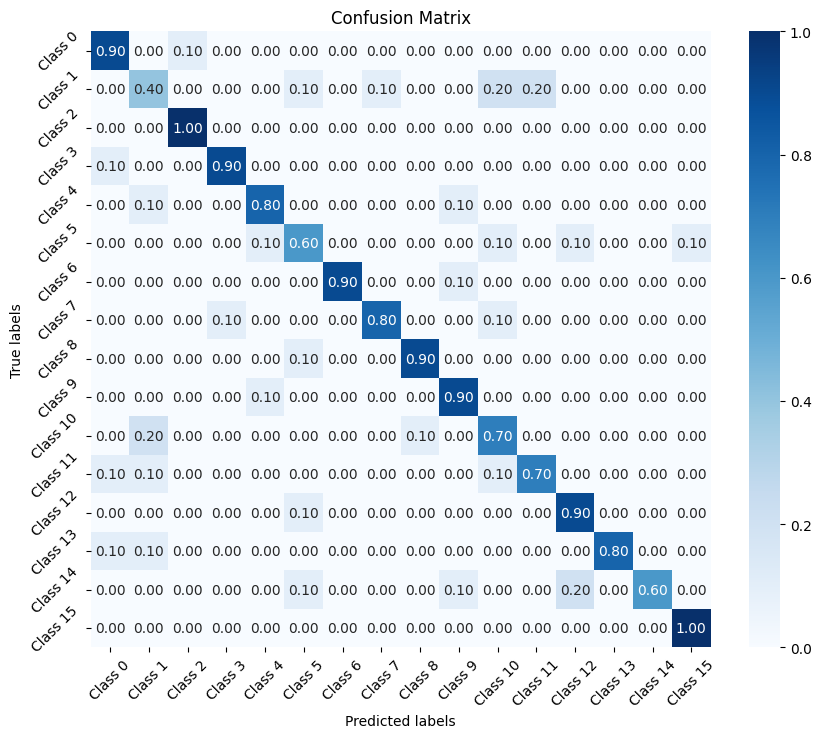

In [20]:
cm = confusion_matrix(labels, preds, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',
            xticklabels=[f'Class {i}' for i in range(num_labels)],
            yticklabels=[f'Class {i}' for i in range(num_labels)])
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()